In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

import sys
sys.path.insert(1, '/opt/ml/semantic-segmentation-level2-cv-06/')
from utils import label_accuracy_score, add_hist

# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
plt.rcParams['axes.grid'] = False

In [3]:
dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

In [4]:
categories = dataset['categories']
category_names = []
for cat in categories:
    category_names.append(cat['name'])
category_names.insert(0,'Background')
category_names

['Background',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [5]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
    
class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [6]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'
batch_size = 32
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([ToTensorV2()])
val_transform = A.Compose([ToTensorV2()])
test_transform = A.Compose([ToTensorV2()])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
#val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
#test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=batch_size,
#                                          shuffle=False,
#                                          num_workers=4,
#                                          collate_fn=collate_fn)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           num_workers=4,
#                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.02s)
creating index...
index created!


In [8]:
class_colormap = pd.read_csv("./class_dict.csv")
class_colormap

name    r    g    b
0       Backgroud    0    0    0
1   General trash  192    0  128
2           Paper    0  128  192
3      Paper pack    0  128   64
4           Metal  128    0    0
5           Glass   64    0  128
6         Plastic   64    0  192
7       Styrofoam  192  128   64
8     Plastic bag  192  192  128
9         Battery   64   64  128
10       Clothing  128    0  192

In [9]:
for i, (imgs, masks, image_infos) in enumerate(train_loader):
    #print(len(imgs))
    if i == 51:
        break

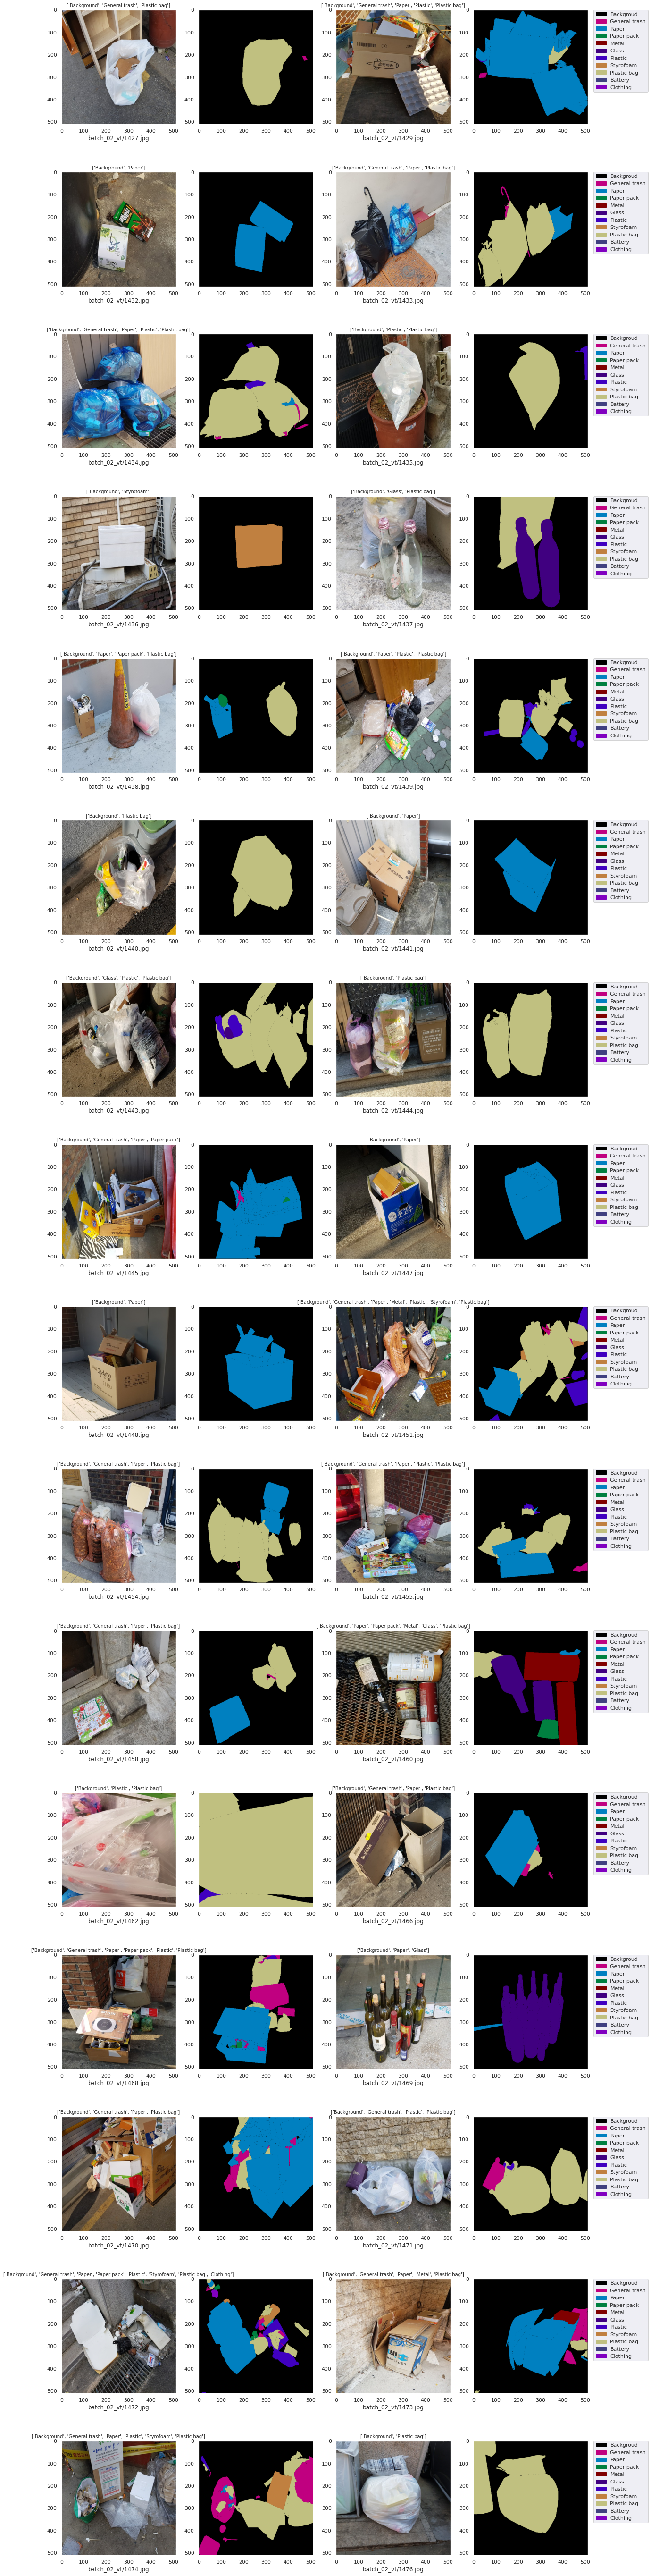

In [10]:
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                         edgecolor=webcolors.rgb_to_hex(rgb), 
                         label=category) for category, rgb in category_and_rgb]

fig, ax = plt.subplots(nrows=16, ncols=4, figsize=(20, 100))
# train_loader의 output 결과(image 및 mask) 확인
for i in range(len(imgs)):
    temp_image_infos = image_infos[i]
    temp_images = imgs[i]
    temp_masks = masks[i]
    
    ax[int(i//2),0 + (i%2)*2].imshow(temp_images.permute([1,2,0]))
    ax[int(i//2),0 + (i%2)*2].grid(False)
    ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
    ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

    ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
    ax[int(i//2),1 + (i%2)*2].grid(False)
    #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
    if (i%2)*2 == 2:
        ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
plt.show()